In [1]:
import json
import os, glob

from itertools import product

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt
import torchaudio

from torchaudio.functional.filtering import lowpass_biquad, highpass_biquad
from torchaudio.transforms import Spectrogram, MelSpectrogram, Resample

from matplotlib import rcParams

from collections import defaultdict

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import helper
from synth.synth_architecture import SynthModular
from config import SynthConfig

from config import configure_experiment
from ai_synth_dataset import AiSynthDataset

import seaborn as sns
sns.set_style('whitegrid')

In [15]:
# Setup experiment

exp_name = ''
dataset_name = 'fm_toy_dataset'
device = 'cuda:1'
resample_op = Resample(orig_freq=16000, new_freq=50).to('cpu')

cfg, model_cfg, synth_cfg, dataset_cfg = configure_experiment(exp_name, dataset_name)

synth = SynthModular(synth_cfg=synth_cfg, sample_rate=cfg.sample_rate, device=device, num_sounds=1,
                     signal_duration_sec=cfg.signal_duration_sec, preset=synth_cfg.preset)

dataset = AiSynthDataset(dataset_cfg.train_parameters_file, dataset_cfg.train_audio_dir, device)

target_sample = dataset[11]
target_signal, target_param_dict, signal_index = target_sample

target_signal = target_signal.to(device)

synth.update_cells_from_dict(target_param_dict)

Deleting previous experiment...


In [42]:
loss_handler = helper.SpectralLoss(cfg=cfg,
                                   fft_sizes=(2048, 1024, 512, 256, 128, 64),
                                   loss_type='L1',
                                   mag_weight=0,
                                   delta_time_weight=10,
                                   delta_freq_weight=0,
                                   cumsum_freq_weight=0,
                                   cumsum_time_weight=1,
                                   logmag_weight=0,
                                   normalize_by_size=True,
                                   device=device)

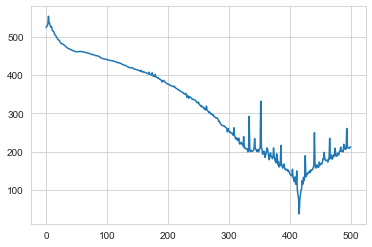

In [43]:
lfo_freq_vals = np.linspace(0, 20, 500)

losses = []
for freq_val in lfo_freq_vals:

    synth.update_cells_from_dict({(0,0): {'operation': 'lfo', 'parameters' :{'freq': freq_val}}})
    signal, _ = synth.generate_signal()

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()

    loss_val = loss_handler.call(target_signal, signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses.append(loss_val.detach().cpu().numpy())

plt.plot(losses)
plt.show()

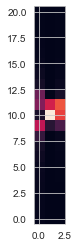

In [107]:
spec_op = Spectrogram(n_fft=40)

spec = spec_op(resampled_target_signal)

plt.imshow(spec.squeeze(), origin='lower')